In [1]:
import numpy as np
from Bio.PDB import PDBParser
from collections import defaultdict

In [3]:
VOXEL_SIZE = 1.0  # Å
GRID_SIZE = 32  # 32x32x32
ATOM_TYPES = ['C', 'N', 'O', 'S']  # 주요 원자 종류 (채널)
CHANNELS = len(ATOM_TYPES)

In [4]:
def get_atom_channel(atom_name):
    for i, t in enumerate(ATOM_TYPES):
        if atom_name.startswith(t):
            return i
        return None

In [13]:
def get_structure_coords(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('mol', pdb_file)
    atoms = []
    for atom in structure.get_atoms():
        pos = atom.get_coord()
        name = atom.element.strip()
        atoms.append((pos, name))
    return atoms

In [81]:
def get_ligand_center(ligand_pdb_path, ligand_resname='UNK'):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('ligand', ligand_pdb_path)
    
    coords = []
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == ligand_resname:
                    for atom in residue:
                        coords.append(atom.coord)

    if len(coords) == 0:
        raise ValueError(f"No ligand atoms found with resname {ligand_resname}")
    
    coords = np.array(coords)
    center = coords.mean(axis=0)
    
    return center

In [15]:
def make_voxel_grid(atom_list, center, grid_size=32, voxel_size=1.0):
    # grid 0으로 초기화
    grid = np.zeros((CHANNELS, grid_size, grid_size, grid_size), dtype=np.float32)
    half = grid_size * voxel_size / 2
    for pos, name in atom_list:
        x, y, z = pos - center + half
        i, j, k = (int(x//voxel_size), int(y//voxel_size), int(z//voxel_size))    #위치 좌표를 grid index로 변환
        ch = get_atom_channel(name)
        if 0 <= i < grid_size and 0 <= j < grid_size and 0 <= k < grid_size and ch is not None:
            grid[ch, i, j, k] = 1.0
    return grid

In [8]:
def make_label_grid(water_list, center, grid_size=32, voxel_size=1.0):
    label = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)
    half = grid_size * voxel_size / 2
    for pos, _ in water_list:
        x, y, z = pos - center + half
        i, j, k = (int(x // voxel_size), int(y // voxel_size), int(z // voxel_size))
        if 0 <= i < grid_size and 0 <= j < grid_size and 0 <= k < grid_size:
            label[i, j, k] = 1
    return label

In [9]:
def prepare_sample_with_ligand(prot_pdb, hs_pdb, lig_pdb):
    prot_atoms = get_structure_coords(prot_pdb)
    water_atoms = get_structure_coords(hs_pdb)
    center = get_center_ligand(lig_pdb)

    voxel_X = make_voxel_grid(prot_atoms, center)
    voxel_Y = make_label_grid(water_atoms, center)

    return voxel_X, voxel_Y

In [17]:
prot_file = "/Users/yeonji/Dropbox/myfolder_data/wbp_last/ahr_eq/avg/xiap_ahr_eq_l20_avg.pdb"
hs_file = "/Users/yeonji/Dropbox/myfolder_data/wbp_last/ahr_eq/cc/xiap_ahr_eq_cc.pdb"
lig_file = "/Users/yeonji/Dropbox/myfolder_data/Binding_Site_Reorganization/min_ahr_aligned/ahr_aligned_complex/lig/xiap_lig_min_ahr_aligned.pdb"
X, Y = prepare_sample_with_ligand(prot_file, hs_file, lig_file)
print(X.shape)
print(Y.shape)

(4, 32, 32, 32)
(32, 32, 32)


3. PyTorch Dataset Class

In [19]:
import torch
from torch.utils.data import Dataset

class HydrationDataset(Dataset):
    def __init__(self, prot_list, hs_list, lig_list):
        self.prot_list = prot_list
        self.hs_list = hs_list
        self.lig_list = lig_list

    def __len__(self):
        return len(self.prot_list)

    def __getitem__(self, idx):
        X, Y = prepare_sample_with_ligand(self.prot_list[idx], self.hs_list[idx], self.lig_list[idx])
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(0)    # (1, D, H, W)

        return X, Y

4. 3D CNN Model

In [116]:
import torch.nn as nn
class HydrationCNN(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 32, 3, padding=1),      # 5 -> 32 channels
            nn.ReLU(),
            nn.Conv3d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),                               # downsampling 32 to 16 (voxel not channel)

            nn.Conv3d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, 2, stride=2),      # Upsampling (4->8)
            nn.ReLU(),

            nn.ConvTranspose3d(64, 32, 2, stride=2),       # 8->16
            nn.ReLU(),

            nn.ConvTranspose3d(32, 32, 2, stride=2),       # 16->32
            nn.ReLU(),

            nn.Conv3d(32, 1, 1),                           # 1 channel: possibility of HS each voxel
            # nn.Sigmoid()                                   # 0-1 possibility
            
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

5. Train Loop

In [110]:
from torch.utils.data import DataLoader
device = torch.device("cpu")
def train_model(model, dataloader, epochs=50, lr=1e-3, device="cpu"):
    model = model.to(device)
    pos_weight = torch.tensor([10.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Binary Cross Entropy, HS or not-> binary
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0                                     # initialize loss as 0 each epoch
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            pred = model(X)
            loss = criterion(pred, Y)
            
            optimizer.zero_grad()                            # initialize prev gradient 
            loss.backward()                                  # calculate gradient for current loss (back propagation)
            optimizer.step()                                 # update model parameters
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(dataloader):.4f}")

In [46]:
import matplotlib.pyplot as plt
def vis_predictions(model, dataset, index=0):
    model.eval()
    X, Y = dataset[index]
    with torch.no_grad():                                    # not training, grad off
        pred = model(X.unsqueeze(0)).squeeze(0).squeeze(0).numpy()        # add bach dim (unsqueeze), squeeze & squeeze -> 3D
        true = Y.squeeze(0).numpy()
        
    z = pred.shape[2] // 2

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Prediction")
    plt.imshow(pred[:, :, z], cmap='hot')
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(true[:, :, z], cmap='hot')
    plt.show

In [25]:
import glob
prot_file = sorted(glob.glob("/Users/yeonji/Dropbox/myfolder_data/wbp_last/ahr_eq/avg/*.pdb"))
hs_file = sorted(glob.glob("/Users/yeonji/Dropbox/myfolder_data/wbp_last/ahr_eq/cc/*.pdb"))
lig_file = sorted(glob.glob("/Users/yeonji/Dropbox/myfolder_data/Binding_Site_Reorganization/min_ahr_aligned/ahr_aligned_complex/lig/*.pdb"))

In [71]:
dataset = HydrationDataset(prot_file, hs_file, lig_file)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [118]:
model = HydrationCNN(in_channels=4)

In [119]:
train_model(model, dataloader, epochs=50)

Epoch 1/50 | Loss: 0.2467
Epoch 2/50 | Loss: 0.0496
Epoch 3/50 | Loss: 0.0455
Epoch 4/50 | Loss: 0.0415
Epoch 5/50 | Loss: 0.0415
Epoch 6/50 | Loss: 0.0425
Epoch 7/50 | Loss: 0.0412
Epoch 8/50 | Loss: 0.0427
Epoch 9/50 | Loss: 0.0387
Epoch 10/50 | Loss: 0.0378
Epoch 11/50 | Loss: 0.0365
Epoch 12/50 | Loss: 0.0353
Epoch 13/50 | Loss: 0.0364
Epoch 14/50 | Loss: 0.0384
Epoch 15/50 | Loss: 0.0342
Epoch 16/50 | Loss: 0.0355
Epoch 17/50 | Loss: 0.0351
Epoch 18/50 | Loss: 0.0373
Epoch 19/50 | Loss: 0.0355
Epoch 20/50 | Loss: 0.0333
Epoch 21/50 | Loss: 0.0330
Epoch 22/50 | Loss: 0.0364
Epoch 23/50 | Loss: 0.0328
Epoch 24/50 | Loss: 0.0318
Epoch 25/50 | Loss: 0.0345
Epoch 26/50 | Loss: 0.0324
Epoch 27/50 | Loss: 0.0319
Epoch 28/50 | Loss: 0.0309
Epoch 29/50 | Loss: 0.0330
Epoch 30/50 | Loss: 0.0304
Epoch 31/50 | Loss: 0.0304
Epoch 32/50 | Loss: 0.0317
Epoch 33/50 | Loss: 0.0318
Epoch 34/50 | Loss: 0.0312
Epoch 35/50 | Loss: 0.0278
Epoch 36/50 | Loss: 0.0291
Epoch 37/50 | Loss: 0.0284
Epoch 38/5

In [130]:
def save_prediction_as_pdb_real(pred, center, file_name, threshold=0.5, spacing=1.0):

    output_path = "/Users/yeonji/Desktop/ComputerProject/CNN_HS_Predict/3d_CNN_HS_preds/deepCNN_0.3/"
    grid_size = np.array(pred.shape)  # (32, 32, 32)
    half_grid = grid_size / 2.0

    coords = np.argwhere(pred > threshold)  # (i, j, k) 인덱스 리스트

    with open(output_path + file_name, 'w') as f:
        for i, (x_idx, y_idx, z_idx) in enumerate(coords):
            # voxel index를 real-world coordinate로 변환
            fx = center[0] + (x_idx - half_grid[0]) * spacing
            fy = center[1] + (y_idx - half_grid[1]) * spacing
            fz = center[2] + (z_idx - half_grid[2]) * spacing

            f.write(
                f"HETATM{i:5d}  O   HOH A{i%10000:4d}    {fx:8.3f}{fy:8.3f}{fz:8.3f}  1.00 20.00           O\n"
            )

In [91]:
import matplotlib.pyplot as plt

def plot_pred_histogram(pred):
    plt.hist(pred.flatten(), bins=50)
    plt.title("Predicted Voxel Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Number of Voxels")
    plt.grid(True)
    plt.show()

In [131]:
for i, prot in enumerate(prot_file):
    prot_name = prot.split("/")[-1].split("_")[0]
    file_name = prot_name + "_hs_pred.pdb"
    for lig in lig_file:
        if prot_name in lig:
            center = get_ligand_center(lig)
            X, Y = dataset[i]
            
            model.eval()
            with torch.no_grad():
                pred = model(X.unsqueeze(0))
                pred = torch.sigmoid(pred)
                pred = pred.squeeze(0).squeeze(0).numpy()
    save_prediction_as_pdb_real(pred, center, file_name, threshold=0.3)

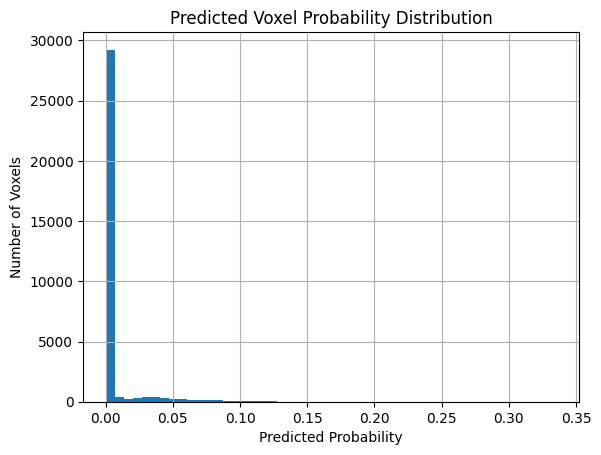

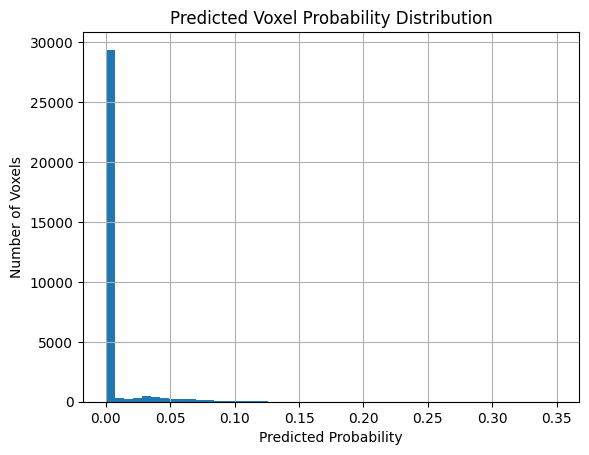

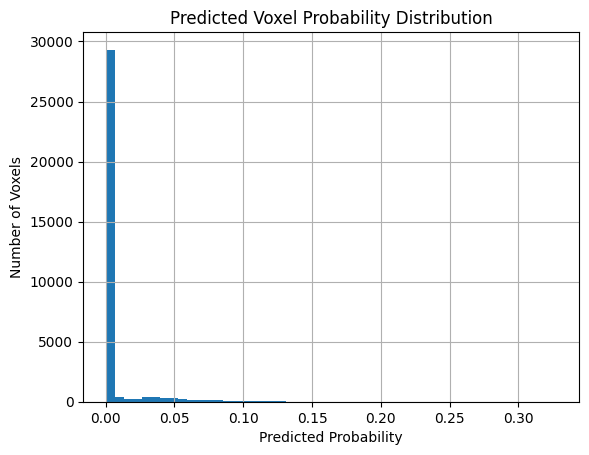

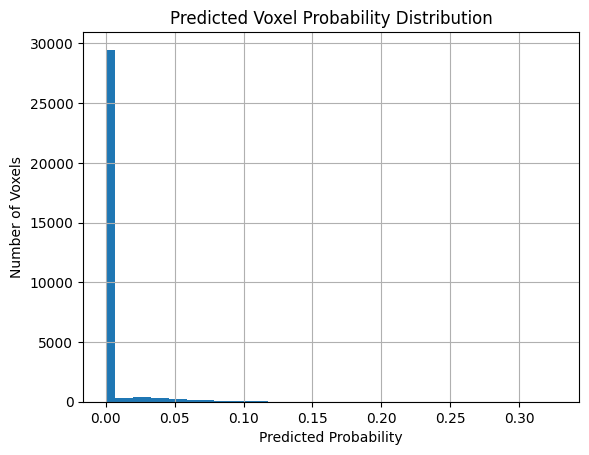

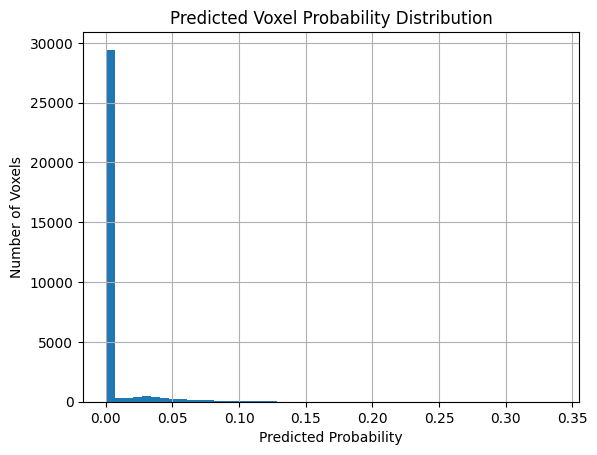

In [127]:
for i, prot in enumerate(prot_file[0:5]):
    prot_name = prot.split("/")[-1].split("_")[0]

    X, Y = dataset[i]
    
    model.eval()
    with torch.no_grad():
        pred = model(X.unsqueeze(0))
        pred = torch.sigmoid(pred)
        pred = pred.squeeze(0).squeeze(0).numpy()
    plot_pred_histogram(pred)